# Explict bounds for eigenvalues of the Laplacian by finite element method

## Summary
    
- Calculate the lower bounds for the leading eigenvalues of the Laplacian by using the non-conforming finite element method. 

- The Crouzeix-Rarviart (CR) finite element method will be used to provide lower eigenvalue bounds; such a method even works for non-convex domain.

- The lower and upper eigenvalue bounds for L-shaped domain are also given at the end of this file.

### Reference
-  [A framework of verified eigenvalue bounds for self-adjoint differential operators, Xuefeng LIU, AMC-2015](https://www.sciencedirect.com/science/article/pii/S0096300315003628)


## Introduction

On a square domain $\Omega$, consider the following eigenvalue problem

$$
-\Delta u = \lambda u \mbox{ in } \Omega, u=0 \mbox{ on } \partial \Omega \:.
$$

The variational formulation for the above eigenvalue problem is to find $u\in H_0^1(\Omega)$ and $\lambda \in R$ such that
$$
\int_{\Omega} \nabla u \cdot \nabla v dx = \lambda \int_{\Omega} uvdx \mbox{ for all }  v \in H_0^1(\Omega) \:.
$$

Below, we show how to solve the eigenvalue problem along with explicit lower and upper bounds for the eigenvalues.

Particular, in case of the domain being the unit square, the first 9 eigenvalues are given by 
$$
\left\{\frac{\lambda_i}{\pi^2} \right\}_{i=1}^{9}  = \{2,5,5,8,10,10,13,13,18\} \:.
$$


<em>Last updated by Xuefeng LIU, Dec. 15, 2019</em> (http://xfliu.org)


## Step 1 : Mesh generation and FEM space definition

In [51]:
from dolfin import *
import numpy as np

N=32; h=1.0/N
mesh = UnitSquareMesh(N, N)
V = FunctionSpace(mesh, "CR", 1)

# define Dirichlet boundary conditions
def bdry(x, on_boundary):  return on_boundary

bc = DirichletBC(V, Constant(0.0), bdry)

## Step 2: Variational formulation

In [52]:
# Define basis and bilinear form
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v))*dx
b = dot(u, v)*dx

L = v*dx # To feed an argument to assemble_system

# Assemble the stiffness matrix and the mass matrix.
A, _ = assemble_system(a, L, bc) #The assemble_system commands make sure the symmetry of A
# A = assemble(a)
B = assemble(b)

# set the diagonal elements of B corresponding to boundary nodes to zero to
# remove spurious eigenvalues.
bc.zero(B)

# downcast to PETSc matrices
MatA = as_backend_type(A)
MatB = as_backend_type(B)


## Step 3: Calculate matrix and solve the matrix eigenvalue problem

In [54]:
#An eigenvalue solver from scipy.
def get_leading_eigenvalues(MatA, MatB, nreq):
    
    import numpy as np
    from scipy.sparse.linalg import eigsh
    import scipy.sparse as sp
    
    row_,col_,val_ = MatA.mat().getValuesCSR()
    sA = sp.csr_matrix((val_,col_,row_))
    row_,col_,val_ = MatB.mat().getValuesCSR()
    sB = sp.csr_matrix((val_,col_,row_))
    
    #Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html
    #Since the "LM" calculation is more stable,we first fetch the largest eigenvalues of Mx=lambda Ax and then take the reverse.
    reverse_eigenvalues, reverse_eigenvectors = eigsh(sB,k=nreq, M=sA,which="LM", return_eigenvectors=True, mode="normal")
    eigenvalues = 1./reverse_eigenvalues
    eigenvalues.sort()
    return eigenvalues, np.flip(reverse_eigenvectors,1)

## Step 4: Approximate eigenvalues obtained by CR FEM

In [55]:
exact_eigvalues = np.array([2,5,5,8,10,10,13,13,18])*pi**2;

nreq=9
[eigen_values, eigen_vectors]= get_leading_eigenvalues(MatA, MatB, nreq)

# Extract the leading eigenpair from the smallest eigenvalue.
for k in range(nreq):
    eig = eigen_values[k]
    exact_eig = exact_eigvalues[k]
    print("The %dth approximate eigenvalue:%8.3f*pi^2 (exact one:%4d*pi^2)"%(k+1, eig/(pi**2), np.rint(exact_eig/(pi**2))))

The 1th approximate eigenvalue:   1.999*pi^2 (exact one:   2*pi^2)
The 2th approximate eigenvalue:   4.993*pi^2 (exact one:   5*pi^2)
The 3th approximate eigenvalue:   4.993*pi^2 (exact one:   5*pi^2)
The 4th approximate eigenvalue:   7.991*pi^2 (exact one:   8*pi^2)
The 5th approximate eigenvalue:   9.961*pi^2 (exact one:  10*pi^2)
The 6th approximate eigenvalue:   9.961*pi^2 (exact one:  10*pi^2)
The 7th approximate eigenvalue:  12.967*pi^2 (exact one:  13*pi^2)
The 8th approximate eigenvalue:  12.967*pi^2 (exact one:  13*pi^2)
The 9th approximate eigenvalue:  16.871*pi^2 (exact one:  18*pi^2)


## Step 5: Draw the eigenfunction

Choose eig_index from 1 to 9 and check the shape of eigenfunction.

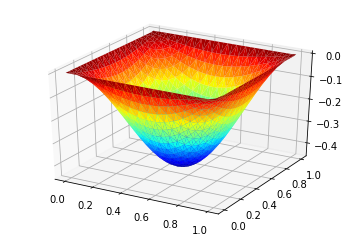

In [56]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

#Choose eige_index from 1 to 9.
eig_index=1
rx = eigen_vectors[:,eig_index-1]

nodes = mesh.coordinates()
x = nodes[:,0]; y = nodes[:,1]

u = Function(V)
u.vector()[:] = rx 
z = u.compute_vertex_values(mesh)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.1)
plt.show()

## 6. Lower eigenvalue bounds
    
Calculate  the lower bounds for the leading 9 exact eigenvalues. To give lower bound, we need the following error estimation for projection ($P_h$) to CR FEM space

$$ \| u - P_h u \| \le 0.1893h \| \nabla(u - P_h u) \| $$

where $h$ is the maximum edge length of triangulation of the domain. 

- Reference: [A framework of verified eigenvalue bounds for self-adjoint differential operators, Xuefeng LIU, AMC-2015](https://www.sciencedirect.com/science/article/pii/S0096300315003628)


### Notice 
This method works even for non-convex domain.


In [57]:
Ch=0.1893*h;

exact_eigvalues = np.array([2,5,5,8,10,10,13,13,18])*pi**2;

# Extract the leading eigenpair from the smallest eigenvalue.
for k in range(0,nreq):
    eig_value = eigen_values[k]
    exact_eig = exact_eigvalues[k]
    lower_bound = eig_value/(1+Ch*Ch*eig_value)
    print("The lower bound of the %dth eigenvalue: %10.5f (< %10.5f)  (Difference: %10.5f) "%(k+1, lower_bound, exact_eig, exact_eig - lower_bound ))


The lower bound of the 1th eigenvalue:   19.72030 (<   19.73921)  (Difference:    0.01890) 
The lower bound of the 2th eigenvalue:   49.19447 (<   49.34802)  (Difference:    0.15356) 
The lower bound of the 3th eigenvalue:   49.19447 (<   49.34802)  (Difference:    0.15356) 
The lower bound of the 4th eigenvalue:   78.65515 (<   78.95684)  (Difference:    0.30169) 
The lower bound of the 5th eigenvalue:   97.97299 (<   98.69604)  (Difference:    0.72305) 
The lower bound of the 6th eigenvalue:   97.97299 (<   98.69604)  (Difference:    0.72305) 
The lower bound of the 7th eigenvalue:  127.41162 (<  128.30486)  (Difference:    0.89324) 
The lower bound of the 8th eigenvalue:  127.41162 (<  128.30486)  (Difference:    0.89324) 
The lower bound of the 9th eigenvalue:  165.54388 (<  177.65288)  (Difference:   12.10900) 


## Setp 7. Upper and Lower eigenvalue bounds for L-shaped domain

We apply the method described above to L-shaped domain. Please make sure the L_uniform.xml is uploaded to the same folder.

First, let check the mesh for L-shaped domain. Use L_uniform.xml as inital mesh. By refine this mesh, we have dense uiform mesh.

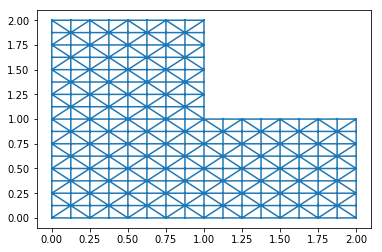

In [58]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.tri as tri

N=4; h=1.0/N
mesh = Mesh("L_uniform.xml")
for k in range(0,N-1):
    mesh = refine(mesh)
    
nodes = mesh.coordinates();
elements = tri.Triangulation(nodes[:, 0], nodes[:, 1], mesh.cells());
plt.triplot(elements)
plt.show()

### 7.1 Lower bound

In [59]:
V = FunctionSpace(mesh, "CR", 1)

# define Dirichlet boundary conditions
def bdry(x, on_boundary):  return on_boundary

bc = DirichletBC(V, Constant(0.0), bdry)

# Define basis and bilinear form
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v))*dx
b = dot(u, v)*dx

L = v*dx # To feed an argument to assemble_system

# Assemble the stiffness matrix and the mass matrix.
A, _ = assemble_system(a, L, bc) #The assemble_system commands make sure the symmetry of A
B = assemble(b)
bc.zero(B)

# downcast to PETSc matrices
MatA = as_backend_type(A)
MatB = as_backend_type(B)

nreq=9
# Extract the leading eigenpair from the smallest eigenvalue.
[eigen_values, eigen_vectors]= get_leading_eigenvalues(MatA, MatB, nreq)

Ch=0.1893*h;

print("\nLower bound of eigenvalues")

lower_bound_list = []
for k in range(nreq):
    eig_value = eigen_values[k]
    lower_bound = eig_value/(1+Ch*Ch*eig_value)
    lower_bound_list.append(lower_bound)
    print("The lower bound of %d theigenvalue: %10.4f"%(k+1, lower_bound))


Lower bound of eigenvalues
The lower bound of 1 theigenvalue:     9.2649
The lower bound of 2 theigenvalue:    14.6151
The lower bound of 3 theigenvalue:    18.8258
The lower bound of 4 theigenvalue:    27.3925
The lower bound of 5 theigenvalue:    29.0906
The lower bound of 6 theigenvalue:    36.8914
The lower bound of 7 theigenvalue:    39.8033
The lower bound of 8 theigenvalue:    43.5395
The lower bound of 9 theigenvalue:    43.5395


### 7.2 Upper bound

In [60]:
V = FunctionSpace(mesh, "CG", 1)

# define Dirichlet boundary conditions
def bdry(x, on_boundary):  return on_boundary
bc = DirichletBC(V, Constant(0.0), bdry)

# Define basis and bilinear form
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v))*dx
b = dot(u, v)*dx

L = v*dx # To feed an argument to assemble_system

# Assemble the stiffness matrix and the mass matrix.
A, _ = assemble_system(a, L, bc) #The assemble_system commands make sure the symmetry of A
B = assemble(b)
bc.zero(B)

# downcast to PETSc matrices
MatA = as_backend_type(A)
MatB = as_backend_type(B)

nreq=9
# Extract the leading eigenpair from the smallest eigenvalue.
[eigen_values, eigen_vectors]= get_leading_eigenvalues(MatA, MatB, nreq)


import numpy as np

print("\nApproximate eigenvalues by Lagrange method, which are also the exact upper bounds")

upper_bound_list = []

for k in range(nreq):
    eig_value = eigen_values[k]
    upper_bound_list.append(eig_value)
    print ("The upper bound of %dth eigenvalue:%8.4f"%(k+1, eig_value))


Approximate eigenvalues by Lagrange method, which are also the exact upper bounds
The upper bound of 1th eigenvalue:  9.9230
The upper bound of 2th eigenvalue: 15.5452
The upper bound of 3th eigenvalue: 20.4215
The upper bound of 4th eigenvalue: 30.8980
The upper bound of 5th eigenvalue: 33.8795
The upper bound of 6th eigenvalue: 44.1217
The upper bound of 7th eigenvalue: 47.6094
The upper bound of 8th eigenvalue: 53.0877
The upper bound of 9th eigenvalue: 53.0877


### 7.3 Draw the lower bound and upper bound in graph

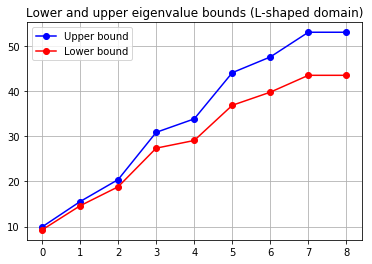

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt

upper_, = plt.plot( range(0,nreq), upper_bound_list, 'bo-',label="Upper bound")
lower_, = plt.plot( range(0,nreq), lower_bound_list, 'ro-',label="Lower bound")

plt.legend(handles=[upper_, lower_ ])

plt.grid()
plt.title("Lower and upper eigenvalue bounds (L-shaped domain)")
plt.show()